# Projet_P5 : Produisez une étude de marché

In [29]:
from functions import *
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from math import pi
import csv
import seaborn as sns
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import chart_studio.plotly as py #For World Map
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
# from functions_init import *
# pip install -U varname
# print('matplotlib: {}'.format(matplotlib.__version__))

##### Téléchargement données FAO

In [30]:
# Exclusion préalable de la Chine en référence au doublon mis en évidence au P3
url   = 'INPUTS_FORMATION/P5_csv_FAO_nv_2018_v_2014.csv'
data  = pd.read_csv(url, sep=',',encoding='utf-8')
table = data.copy()

#-----------------------------------------------------------------------------------------------------------------BLOC VAR ADD
# Choix variables supplémentaires
df = data.copy()
url_var1   = 'INPUTS_FORMATION/P5_csv_FAO_nv_+_elevage_reserves_poulet_2018.csv'
data1  = pd.read_csv(url_var1, sep=',',encoding='utf-8')
df1 = data1.copy()

url_var2   = 'INPUTS_FORMATION/P5_csv_FAO_nv_+_importations_quant_et_price_2018.csv'
data2  = pd.read_csv(url_var2, sep=',',encoding='utf-8')
df2 = data2.copy()

url_var3   = 'INPUTS_FORMATION/P5_csv_FAO_nv_+_stabilite_politique.csv'
data3  = pd.read_csv(url_var3, sep=',',encoding='utf-8')
df3 = data3.copy()

url_var4   = 'INPUTS_FORMATION/P5_csv_FAO_nv_+_prod_imp_exp_volaille.csv'
data4  = pd.read_csv(url_var4, sep=',',encoding='utf-8')
df4 = data4.copy()

url_var5   = 'INPUTS_FORMATION/P5_csv_FAO_nv_+_Rev_Nat_Brut_hbt.csv'
data5  = pd.read_csv(url_var5, sep=',',encoding='utf-8')
df5 = data5.copy()

# Concaténation
frames = [df, df1, df3, df4, df5]
table = pd.concat(frames)
#------------------------------------------------------------------------------------------------------------------------------

table = table[['Code zone', 'Zone', 'Code Élément', 'Élément','Code Produit', 'Produit',
             'Année', 'Unité','Valeur', 'Description du Symbole']]

table = table.pivot_table(index=['Zone','Code zone','Année','Produit','Code Produit'],
                          columns=['Élément'], values='Valeur',
#                         aggfunc=np.sum, 
                          fill_value=0).reset_index()

#-----------------------------------------------------------------------------------------------------------------BLOC VAR ADD
# On renomme la colonne 'Valeur' par Stabilité si considération du df3
table = table.rename(columns={'Valeur':'Stabilité politique'})
# On renomme la colonne 'Valeur' par Revenu National Brut(/hbt) si considération du df5
table = table.rename(columns={'Valeur (US $)':'Revenu National Brut/hbt'})
#------------------------------------------------------------------------------------------------------------------------------
# table.tail()

In [31]:
# on isole la [population] puis détermination de l'évolution 2014 -> 2018 en %
pop = table[table['Produit']=='Population']
pop['evo_pop_18_v_14'] = 100*pop.groupby('Code zone')['Population totale'].agg(['pct_change']).fillna(0) #.diff().fillna(0) ou #.agg(['diff','pct_change']).dropna()
pop['evo_pop_18_v_14'] = pop['evo_pop_18_v_14'].apply(lambda x: "{:.2f}".format(x) if not pd.isnull(x) else x)                                                        
pop = pop[pop['Année']==2018]
pop = pop[['Zone', 'Code zone','Population totale','evo_pop_18_v_14']]

# on sélectionne l'année d'étude N et on merge les 2 tables
table = table[table['Année']==2018]
table = pd.merge(table, pop, how="left", on="Code zone")

table.rename(columns={'Zone_x':'Zone','Population totale_y':'Population_18 (x1000)',
                          'evo_pop_18_v_14':'evo_pop_18_v_14 (%)'}, inplace=True)
table = table[['Zone', 'Code zone', 'Année', 'Produit', 'Code Produit',
               'Disponibilité alimentaire (Kcal/personne/jour)',
                    'Disponibilité de protéines en quantité (g/personne/jour)',
                        'Population_18 (x1000)','evo_pop_18_v_14 (%)',
#-----------------------------------------------------------------------------------------------------------------BLOC VAR ADD
                                                                     'Stabilité politique',
                                                                     'Exportations - Quantité',
                                                                     'Importations - Quantité',
                                                                     'Production',
                                                                     'Réserves',
                                                                     'Revenu National Brut/hbt',
#                                                                    'Valeur des exportations - Prix période de référence',
#                                                                    'Valeur des exportations - Quantité période de référence',
#                                                                    'Valeur des importations - Prix période de référence',
#                                                                    'Valeur des importations - Quantité période de référence'
#------------------------------------------------------------------------------------------------------------------------------
              ]]

table['evo_pop_18_v_14 (%)'] = pd.to_numeric(table['evo_pop_18_v_14 (%)'])
table
# De cette table, on isole et met de côté de nouveau l'indicateur 'evolution pop°'
pop = table[table['Produit']=='Population']

#-----------------------------------------------------------------------------------------------------------------BLOC VAR ADD
stabilite_pol = table[table['Produit']=='Stabilité politique et absence de violence/terrorisme (indice)']
stabilite_pol = stabilite_pol[['Zone','Stabilité politique']]

for i, row in table.iterrows():
        table.loc[i,"D Exports-Imports"] = row['Exportations - Quantité']-row['Importations - Quantité']    
delta_exp_v_imp = table[table['Produit']=='Viande de Volailles']
delta_exp_v_imp = delta_exp_v_imp[['Zone','D Exports-Imports']]

# on crée 2 nouveaux indicateurs : TAUX DE DÉPENDANCE DES IMPORTATIONS (TDI) et TAUX D'AUTOSUFFISANCE (TAS)  
for i, row in table.iterrows():
    try: 
        table.loc[i,'Expor_over_Impor'] = row['Exportations - Quantité']/row['Importations - Quantité']
        table.loc[i,'Tx_depd_importations (%)'] = 100*(row['Importations - Quantité']/(row['Importations - Quantité']+row['Production']-row['Exportations - Quantité']))
    except ZeroDivisionError:
        table.loc[i,'Expor_over_Impor']           = 0
        table.loc[i,'Tx_depd_importations (%)'] = 0        
TDI = table[table['Produit']=='Viande de Volailles']
TDI = TDI[['Zone','Expor_over_Impor','Tx_depd_importations (%)']]

for i, row in table.iterrows():
    try: 
        table.loc[i,'Expor_over_Prod'] = row['Exportations - Quantité']/row['Production']
        table.loc[i,'Tx_autosuffisance (%)'] = 100*(row['Production']/(row['Importations - Quantité']+row['Production']-row['Exportations - Quantité']))
    except ZeroDivisionError:
        table.loc[i,'Expor_over_Prod'] = 0
        table.loc[i,'Tx_autosuffisance (%)'] = 0      
TAS = table[table['Produit']=='Viande de Volailles']
TAS = TAS[['Zone','Expor_over_Prod','Tx_autosuffisance (%)']]
  
reserves = table[table['Produit']=='Poulets']
reserves = reserves[['Zone','Réserves']]

rev_nat_brut = table[table['Produit']=='Revenu national brut par habitant']
rev_nat_brut = rev_nat_brut[['Zone','Revenu National Brut/hbt']]

importations = table[table['Produit']=='Viande de Volailles']
importations = importations[['Zone','Importations - Quantité']]

exportations = table[table['Produit']=='Viande de Volailles']
exportations = exportations[['Zone','Exportations - Quantité']]

productions = table[table['Produit']=='Viande de Volailles']
productions = productions[['Zone','Production']]
       
# imp_exp = table[table['Produit']=='Viande de Volailles']
# imp_exp = imp_exp[['Zone','Valeur des importations - Prix période de référence',
#                    'Valeur des importations - Quantité période de référence',
#                    'Valeur des exportations - Prix période de référence',
#                    'Valeur des exportations - Quantité période de référence']]
#------------------------------------------------------------------------------------------------------------------------------

#### Ratio protéines animales vs total

In [32]:
# on reconstruit la Dispo de protéines en quantité TOTALE
table_add = table.copy()
table = table.pivot_table(index=['Zone', 'Code zone', 'Année', 'Produit', 'Code Produit',
                                 'Disponibilité alimentaire (Kcal/personne/jour)',
                                 'Population_18 (x1000)', 
                                 'evo_pop_18_v_14 (%)',
#-----------------------------------------------------------------------------------------------------------------BLOC VAR ADD
                                                                     'Stabilité politique',
                                                                     'Exportations - Quantité',
                                                                     'Importations - Quantité',
                                                                     'Production',
                                                                     'D Exports-Imports',
                                                                     'Expor_over_Impor',
                                                                     'Expor_over_Prod',
                                                                     'Tx_depd_importations (%)',
                                                                     'Tx_autosuffisance (%)',
                                                                     'Réserves',
                                                                     'Revenu National Brut/hbt',
#                                                                    'Valeur des exportations - Prix période de référence',
#                                                                    'Valeur des exportations - Quantité période de référence',
#                                                                    'Valeur des importations - Prix période de référence',
#                                                                    'Valeur des importations - Quantité période de référence'
#------------------------------------------------------------------------------------------------------------------------------
                                ],
                                  columns=['Produit'], 
                                  values='Disponibilité de protéines en quantité (g/personne/jour)',
                                  aggfunc=np.sum, 
                                  fill_value=0).reset_index(drop=False)

# on somme chacune des produits par pays
table = table.groupby(['Zone']).agg({'Produits Animaux':np.sum,'Produits Vegetaux':np.sum}).reset_index(drop=False)
table['Produits Vegetaux'] = table['Produits Vegetaux'].replace(0 ,np.nan)
table['Produits Animaux'] = table['Produits Animaux'].replace(0 ,np.nan)

# on détermine le ratio A/A+V
for j, row in table.iterrows():
        table.loc[j,"Proportion de protéines d'origine animale (%)"] = 100*(row['Produits Animaux']/(row['Produits Animaux']+row['Produits Vegetaux']))
        table.loc[j,"Disponibilité de protéines en quantité (g/personne/jour)"] = row['Produits Animaux']+row['Produits Vegetaux']
table["Proportion de protéines d'origine animale (%)"] = table["Proportion de protéines d'origine animale (%)"].apply(lambda x: "{:.2f}".format(x) if not pd.isnull(x) else x)                                                        
table["Proportion de protéines d'origine animale (%)"] = pd.to_numeric(table["Proportion de protéines d'origine animale (%)"])

#### Obtention table avec indicateurs : évolution population + proportion protéines

In [33]:
# on merge les 2 tables contenant [evo pop] et [ratio]
table = pd.merge(pop,table, how="left", on="Zone")
table = table[['Zone', 'Code zone', 'Année', 'Produit', 'Code Produit',
               'Disponibilité alimentaire (Kcal/personne/jour)',
               'Population_18 (x1000)', 'evo_pop_18_v_14 (%)', 'Produits Animaux',
               'Produits Vegetaux', 'Disponibilité de protéines en quantité (g/personne/jour)_y',
               "Proportion de protéines d'origine animale (%)",
#                'Exportations - Quantité', 'Importations - Quantité', 'Production'
              ]]

# on reconstruit la Dispo alimentaire kcal TOTALE
table_add = table_add.pivot_table(index=['Zone', 'Code zone', 'Année', 'Produit', 'Code Produit',
                                         'Disponibilité de protéines en quantité (g/personne/jour)',
                                         'Population_18 (x1000)', 
                                         'evo_pop_18_v_14 (%)',
#-----------------------------------------------------------------------------------------------------------------BLOC VAR ADD
                                                                     'Stabilité politique',
                                                                     'Exportations - Quantité',
                                                                     'Importations - Quantité',
                                                                     'Production',
                                                                     'D Exports-Imports',
                                                                     'Expor_over_Impor',
                                                                     'Expor_over_Prod',
                                                                     'Tx_depd_importations (%)',
                                                                     'Tx_autosuffisance (%)',
                                                                     'Réserves',
                                                                     'Revenu National Brut/hbt',
#                                                                    'Valeur des exportations - Prix période de référence',
#                                                                    'Valeur des exportations - Quantité période de référence',
#                                                                    'Valeur des importations - Prix période de référence',
#                                                                    'Valeur des importations - Quantité période de référence'
#------------------------------------------------------------------------------------------------------------------------------
                                        ],
                                              columns=['Produit'], 
                                              values='Disponibilité alimentaire (Kcal/personne/jour)',
                                              aggfunc=np.sum, 
                                              fill_value=0).reset_index()

# on somme chacune des produits par pays
table_add = table_add.groupby(['Zone']).agg({'Produits Animaux':np.sum,'Produits Vegetaux':np.sum}).reset_index(drop=False)
# on reconstruit la Sum Dispo (Kcal)
for j, row in table_add.iterrows():
        table_add.loc[j,"Disponibilité alimentaire (Kcal/personne/jour)"] = row['Produits Animaux']+row['Produits Vegetaux']

# on merge les 2 tables contenant [evo pop] et [ratio] et la reconstruction des 2 Disponibilités (prot & alim)
table_vf = pd.merge(table,table_add, how="left", on="Zone")
table_vf.rename(columns={'Produits Animaux_x':'Prod Anmx Disprot',
                       'Produits Vegetaux_x':'Prod Vgtx Disprot',
    'Disponibilité de protéines en quantité (g/personne/jour)_y':'Disponibilité de protéines en quantité (g/personne/jour)',
                            'Produits Animaux_y':'Prod Anmx Dispalim', 
                            'Produits Vegetaux_y':'Prod Vgtx Dispalim',
    'Disponibilité alimentaire (Kcal/personne/jour)_y':'Disponibilité alimentaire (Kcal/personne/jour)'}, inplace=True)

table_vf_pop = table_vf[['Zone','Population_18 (x1000)']]
table_vf = table_vf[['Zone','Code zone', 'Année','Population_18 (x1000)',
                    'evo_pop_18_v_14 (%)', "Proportion de protéines d'origine animale (%)",
                    'Prod Anmx Disprot','Prod Vgtx Disprot','Disponibilité de protéines en quantité (g/personne/jour)',
                    'Prod Anmx Dispalim','Prod Vgtx Dispalim','Disponibilité alimentaire (Kcal/personne/jour)',
#                   'Exportations - Quantité', 'Importations - Quantité', 'Production',
                    ]]
table_vf.set_index('Zone',inplace=True)
table_vf.head()

,Code zone,Année,Population_18 (x1000),evo_pop_18_v_14 (%),Proportion de protéines d'origine animale (%),Prod Anmx Disprot,Prod Vgtx Disprot,Disponibilité de protéines en quantité (g/personne/jour),Prod Anmx Dispalim,Prod Vgtx Dispalim,Disponibilité alimentaire (Kcal/personne/jour)
Zone,,,,,,,,,,,
Afghanistan,2,2018,37172.0,11.39,19.43,10.79,44.73,55.52,191,1849,2040.0
Afrique du Sud,202,2018,57793.0,5.96,42.71,36.03,48.33,84.36,479,2420,2899.0
Albanie,3,2018,2883.0,-0.45,53.35,61.75,54.00,115.75,1003,2357,3360.0
Algérie,4,2018,42228.0,8.49,26.93,24.73,67.10,91.83,390,2932,3322.0
Allemagne,79,2018,83124.0,2.06,60.75,64.03,41.37,105.40,1086,2468,3554.0


#### Création des 2 derniers indicateurs proposés: Disponibilité protéines + Disponibilité calories

In [34]:
# on détermine les 2 autres indicateurs demandés
for j, row in table_vf.iterrows():
        table_vf.loc[j,"Disponibilité alimentaire en protéines (kg/hbt)"] = 1e-3*365*row['Disponibilité de protéines en quantité (g/personne/jour)']
        table_vf.loc[j,"Disponibilité alimentaire en calories (Kcal/hbt)"]= 365*row['Disponibilité alimentaire (Kcal/personne/jour)']

# on fait une sélection finale
table_vf = table_vf[['Code zone','evo_pop_18_v_14 (%)','Population_18 (x1000)', "Proportion de protéines d'origine animale (%)",
                     'Disponibilité alimentaire en protéines (kg/hbt)','Disponibilité alimentaire en calories (Kcal/hbt)',
#                    'Exportations - Quantité', 'Importations - Quantité', 'Production'
                    ]]
table_vf['Disponibilité alimentaire en protéines (kg/hbt)']  = table_vf['Disponibilité alimentaire en protéines (kg/hbt)'].apply(lambda x: "{:.2f}".format(x) if not pd.isnull(x) else x)                                                        
table_vf['Disponibilité alimentaire en calories (Kcal/hbt)'] = table_vf['Disponibilité alimentaire en calories (Kcal/hbt)'].apply(lambda x: "{:.0f}".format(x) if not pd.isnull(x) else x)                                                        
table_vf['Disponibilité alimentaire en protéines (kg/hbt)']  = pd.to_numeric(table_vf['Disponibilité alimentaire en protéines (kg/hbt)'])
table_vf['Disponibilité alimentaire en calories (Kcal/hbt)'] = pd.to_numeric(table_vf['Disponibilité alimentaire en calories (Kcal/hbt)'] )

# Suppression ligne pays 'Papouasie Nv_Calédonie' où évolution population méconnue
table_vf = table_vf.drop(table_vf[table_vf['Code zone'] ==168].index, inplace=False)
table_vf.head()

,Code zone,evo_pop_18_v_14 (%),Population_18 (x1000),Proportion de protéines d'origine animale (%),Disponibilité alimentaire en protéines (kg/hbt),Disponibilité alimentaire en calories (Kcal/hbt)
Zone,,,,,,
Afghanistan,2,11.39,37172.0,19.43,20.26,744600
Afrique du Sud,202,5.96,57793.0,42.71,30.79,1058135
Albanie,3,-0.45,2883.0,53.35,42.25,1226400
Algérie,4,8.49,42228.0,26.93,33.52,1212530
Allemagne,79,2.06,83124.0,60.75,38.47,1297210


#### Merge des variables additionnelles au df princiapl

In [35]:
# on merge avec la(les) table(s) contenant la(les) var supp
table_vf = pd.merge(table_vf,stabilite_pol, how="left", on="Zone")
table_vf = pd.merge(table_vf,delta_exp_v_imp, how="left", on="Zone")
table_vf = pd.merge(table_vf,TDI, how="left", on="Zone")
table_vf = pd.merge(table_vf,TAS, how="left", on="Zone")
table_vf = pd.merge(table_vf,reserves, how="left", on="Zone")
table_vf = pd.merge(table_vf,rev_nat_brut, how="left", on="Zone")
table_vf = pd.merge(table_vf,importations, how="left", on="Zone")
table_vf = pd.merge(table_vf,exportations, how="left", on="Zone")
table_vf = pd.merge(table_vf,productions, how="left", on="Zone")

# ajout de variables supplémentaires
url_distance   = 'INPUTS_FORMATION/P5_csv_Distances.csv'
dist           = pd.read_csv(url_distance, sep=';',encoding='utf-8')
distance       = dist.copy()
distance       = distance.dropna()
table_vf = pd.merge(table_vf,distance, how="left", on="Zone")
# table_vf.head()

#### Traitement données

In [36]:
# Eviter message "condensed distance matrix must contain only finite values"
# Hypothèse Stabilité politique régionnale (fonction des îles voisines)
region_poly = table_vf.query(' Zone == ["Fidji","Kiribati","Samoa","Vanuatu","Îles Salomon"]', inplace=False)
average = region_poly['Stabilité politique'].mean()
table_vf['Stabilité politique'].fillna(round(average,2), inplace=True)
table_vf.query(' Zone == ["Nouvelle-Calédonie","Polynésie française"]', inplace=False)

# Hypothèse Réserves (non-utilisée par la suite)
table_vf['Réserves'].fillna(0, inplace=True)

# Hypothèse Revenu National Brut Taïwan = MOY(HK, MACAO)
HK  = table_vf.iloc[int(table_vf[table_vf['Zone']=='Chine - RAS de Hong-Kong'].index[0]),table_vf.columns.get_loc('Revenu National Brut/hbt')]
MAC = table_vf.iloc[int(table_vf[table_vf['Zone']=='Chine - RAS de Macao'].index[0]),table_vf.columns.get_loc('Revenu National Brut/hbt')]
rev_TAI = (HK+MAC)/2
table_vf['Revenu National Brut/hbt'].fillna(round(rev_TAI,0), inplace=True)

print(table_vf.isnull().sum())
# table_vf.to_csv("OUTPUTS_FORMATION/P5_check_finite_values.csv", index = True)
table_vf.set_index('Zone',inplace=True)

table_vf_ALL = table_vf.copy()
table_vf_ALL_radar = table_vf_ALL.copy()
table_vf_ALL.head()

Zone                                                0
Code zone                                           0
evo_pop_18_v_14 (%)                                 0
Population_18 (x1000)                               0
Proportion de protéines d'origine animale (%)       0
Disponibilité alimentaire en protéines (kg/hbt)     0
Disponibilité alimentaire en calories (Kcal/hbt)    0
Stabilité politique                                 0
D Exports-Imports                                   0
Expor_over_Impor                                    0
Tx_depd_importations (%)                            0
Expor_over_Prod                                     0
Tx_autosuffisance (%)                               0
Réserves                                            0
Revenu National Brut/hbt                            0
Importations - Quantité                             0
Exportations - Quantité                             0
Production                                          0
Distance (km)               

,Code zone,evo_pop_18_v_14 (%),Population_18 (x1000),Proportion de protéines d'origine animale (%),Disponibilité alimentaire en protéines (kg/hbt),Disponibilité alimentaire en calories (Kcal/hbt),Stabilité politique,D Exports-Imports,Expor_over_Impor,Tx_depd_importations (%),Expor_over_Prod,Tx_autosuffisance (%),Réserves,Revenu National Brut/hbt,Importations - Quantité,Exportations - Quantité,Production,Distance (km)
Zone,,,,,,,,,,,,,,,,,,
Afghanistan,2,11.39,37172.0,19.43,20.26,744600,-2.75,-25.0,0.000000,46.296296,0.000000,53.703704,14170.0,566.757690,25,0,29,5590
Afrique du Sud,202,5.96,57793.0,42.71,30.79,1058135,-0.28,-467.0,0.093204,23.104531,0.027242,79.048901,172396.0,6210.273812,515,48,1762,9354
Albanie,3,-0.45,2883.0,53.35,42.25,1226400,0.38,-12.0,0.000000,42.857143,0.000000,57.142857,7272.0,5129.722666,12,0,16,1604
Algérie,4,8.49,42228.0,26.93,33.52,1212530,-0.79,0.0,0.000000,0.000000,0.000000,100.000000,137393.0,4077.593095,0,0,295,1340
Allemagne,79,2.06,83124.0,60.75,38.47,1297210,0.60,-231.0,0.734788,48.335183,0.407384,87.180910,0.0,49335.792965,871,640,1571,440


## Part 1 : Clustering

#### Construction du dendrogramme

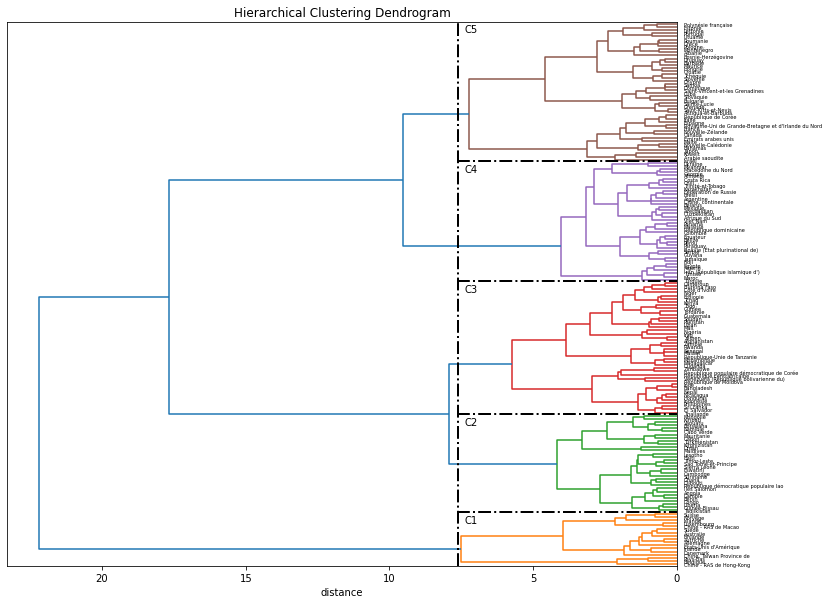

In [37]:
# préparation des données pour le clustering
table_vf = table_vf_ALL[[
#                          'Population_18 (x1000)',
                         'evo_pop_18_v_14 (%)',
                         "Proportion de protéines d'origine animale (%)",
                         'Disponibilité alimentaire en protéines (kg/hbt)',
                         'Disponibilité alimentaire en calories (Kcal/hbt)',
#-----------------------------------------------------------------------------------------------------------------BLOC VAR ADD
                                                                     'Stabilité politique',
                                                                     'Tx_depd_importations (%)',
                                                                     'Revenu National Brut/hbt',
#                                                                      'Tx_autosuffisance (%)',
#                                                                      'D Exports-Imports',
#                                                                      'Réserves',
#                                                                      'Distance (km)',
#                                                                      'Exportations - Quantité',
#                                                                      'Importations - Quantité',
#                                                                      'Production',
#------------------------------------------------------------------------------------------------------------------------------
                        ]]

X     = table_vf.values
names = list(table_vf.index)

# Centrage et Réduction
# std_scale = preprocessing.StandardScaler().fit(X)     #Compute the mean and std to be used for later scaling
std_scale = preprocessing.RobustScaler().fit(X)         #Removes the median and scales the data according to the quantile range
X_scaled  = std_scale.transform(X)                      #Perform standardization by centering and scaling

# Clustering hiérarchique
Z = linkage(X_scaled, method='ward', metric='euclidean', optimal_ordering=False)

# Affichage du dendrogramme
plot_dendrogram(Z, names)
#-----------------------------------------------------------------------------------------------------------------Corr Hyp Stab
plt.axvline(x=7.6  ,color='k',ls='-.',lw=2)                        # avec VAR ADD 'Stab'+'Rev'+'TDI'
plt.axhline(y=170  ,color='k',ls='-.',lw=2,xmin=0.672, xmax=1)   
plt.axhline(y=480  ,color='k',ls='-.',lw=2,xmin=0.672, xmax=1)   
plt.axhline(y=900  ,color='k',ls='-.',lw=2,xmin=0.672, xmax=1)   
plt.axhline(y=1280 ,color='k',ls='-.',lw=2,xmin=0.672, xmax=1) 
plt.annotate('C1', xy=(2, 1), xytext=(7.4, 135))
plt.annotate('C2', xy=(2, 1), xytext=(7.4, 445))
plt.annotate('C3', xy=(2, 1), xytext=(7.4, 865))
plt.annotate('C4', xy=(2, 1), xytext=(7.4, 1245))
plt.annotate('C5', xy=(2, 1), xytext=(7.4, 1690))
#------------------------------------------------------------------------------------------------------------------------------
plt.savefig("OUTPUTS_FORMATION/P5_dendrogram.jpg",dpi=300)
plt.show()

In [38]:
table_vf.dtypes

evo_pop_18_v_14 (%)                                 float64
Proportion de protéines d'origine animale (%)       float64
Disponibilité alimentaire en protéines (kg/hbt)     float64
Disponibilité alimentaire en calories (Kcal/hbt)      int64
Stabilité politique                                 float64
Tx_depd_importations (%)                            float64
Revenu National Brut/hbt                            float64
dtype: object

#### Découpage dendrogramme en 5 groupes

In [39]:
# Coupage du dendrogramme en n clusters
n_cluster = 5
clusters = fcluster(Z, n_cluster, criterion='maxclust')

# Comparaison des clusters trouvés avec les classification des pays
gpe_clust = pd.DataFrame({ "cluster": clusters, "nb_pays": names})
gpe_clust.pivot_table(columns="cluster", aggfunc=len, fill_value=0) 

cluster,1,2,3,4,5
nb_pays,17,31,42,38,44


#### Ajout du cluster associé au dataframe d'étude et export des moyennes par variables

In [40]:
table_vf.insert(1, "Cluster", clusters, allow_duplicates=False)
table_vf.to_csv("OUTPUTS_FORMATION/P5_Liste_pays_groupe.csv", index = True)

table_moy_var = table_vf.groupby(['Cluster']).agg({
#                                                    'Population_18 (x1000)':np.mean,
                                                   'evo_pop_18_v_14 (%)':np.mean,
                                                   "Proportion de protéines d'origine animale (%)":np.mean,
                                                   'Disponibilité alimentaire en protéines (kg/hbt)':np.mean,
                                                   'Disponibilité alimentaire en calories (Kcal/hbt)':np.mean,
#-----------------------------------------------------------------------------------------------------------------BLOC VAR ADD
                                                                     'Stabilité politique':np.mean,
                                                                     'Tx_depd_importations (%)':np.mean,
                                                                     'Revenu National Brut/hbt':np.mean,
#                                                                      'Tx_autosuffisance (%)':np.mean,
#                                                                      'D Exports-Imports':np.mean,
#                                                                      'Réserves':np.mean,
#                                                                      'Distance (km)':np.mean,
#                                                                      'Exportations - Quantité':np.mean,
#                                                                      'Importations - Quantité':np.mean,
#                                                                      'Production':np.mean,
                                                  }).round(2)
#------------------------------------------------------------------------------------------------------------------------------
table_moy_var.to_csv("OUTPUTS_FORMATION/P5_Mean_Var_per_Cluster.csv",index=True)
table_moy_var.head()

,evo_pop_18_v_14 (%),Proportion de protéines d'origine animale (%),Disponibilité alimentaire en protéines (kg/hbt),Disponibilité alimentaire en calories (Kcal/hbt),Stabilité politique,Tx_depd_importations (%),Revenu National Brut/hbt
Cluster,,,,,,,
1,3.35,63.45,40.51,1260838.82,0.96,82.32,63047.13
2,9.22,34.40,23.97,922967.26,0.07,80.01,3517.74
3,8.63,25.51,22.79,892937.74,-1.05,12.86,2127.44
4,4.13,44.77,31.72,1105392.89,-0.29,15.79,6781.00
5,1.19,55.62,35.26,1154478.41,0.61,50.48,22434.19


#### Visualisation des clusters sur Map

In [41]:
# on télécharge les Zones en conformité avec le nb de cluster défini lors du découpage
# /!\ petit travail d'adaptation des clusters par pays à faire (à cause du naming : Fr -> Eng) 
# Ajouter dans url '_plus_VAR' pour le cas avec VAR additionnelle

url   = 'INPUTS_FORMATION/FAO_ENG_'+str(n_cluster)+'_clusters'+'_plus_VAR'+'.csv'
data  = pd.read_csv(url, sep=',',encoding='utf-8')
Pays = data.copy()

my_colors = ['red','blue', 'green','yellow','yellow']

data = [dict(type='choropleth',
             locations = Pays['Area'],
             text      = Pays['Area'], 
             locationmode = 'country names', #'ISO-3', 'USA-states', 'country names', 'geojson-id'
             z = Pays['Cluster'],
             colorbar = {'title':'Cluster Group'},
             marker_line_color='black',
             marker_line_width=0.5,
             zauto=False,
             autocolorscale=False,
             reversescale=False,
             colorscale = my_colors,
             zmin=1,
             zmax=6,
             showscale=True
            )
       ]

layout = dict(title='Grouping of Countries based on Clustering',
              geo=dict(
                          {'scope':'world'},
                          showframe = True, 
                          projection = {'type':'equirectangular'},
                          showcountries = True,
                      )
             )
map3 = dict(data=data, layout=layout)
iplot(map3)

#### Lectures ACP

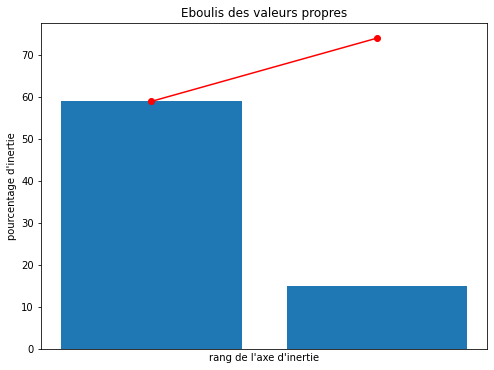

           centroid_x_c1  centroid_y_c1
cluster 1       3.489028       1.124668
           centroid_x_c2  centroid_y_c2
cluster 2      -0.994335       0.688319
           centroid_x_c3  centroid_y_c3
cluster 3      -1.568035         0.2991
           centroid_x_c4  centroid_y_c4
cluster 4      -0.290885      -0.642281
           centroid_x_c5  centroid_y_c5
cluster 5         1.1005       -0.65029


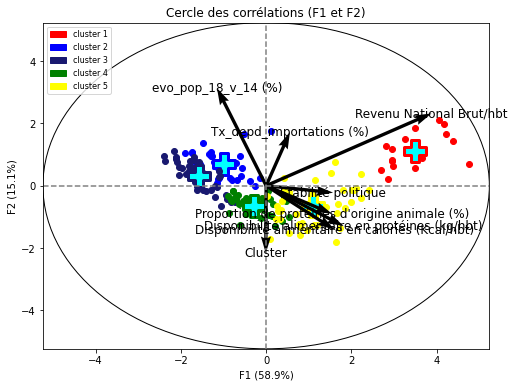

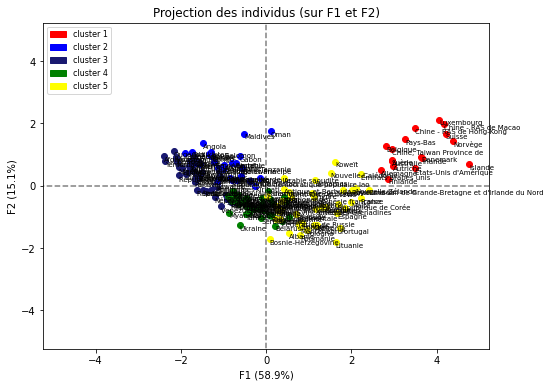

In [42]:
# Choix du nombre de composantes à calculer
n_comp = 2                                    # Nbmaxi = Min(p,n-1) = Min(4,172-1)

# selection des colonnes à prendre en compte dans l'ACP
data_pca = table_vf

# préparation des données pour l'ACP
# data_pca = data_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X        = data_pca.values
names    = list(data_pca.index)
features = data_pca.columns

# Centrage et Réduction
# std_scale = preprocessing.StandardScaler().fit(X)     #Compute the mean and std to be used for later scaling
std_scale = preprocessing.RobustScaler().fit(X)         #Removes the median and scales the data according to the quantile range
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Projection des individus
X_projected = pca.transform(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)
plt.xticks([])
plt.savefig("OUTPUTS_FORMATION/P5_eboulis.jpg",dpi=300)
plt.show()

# Cercle des corrélations
pcs = pca.components_

# Adaptation de la fonction pr obtention 2 infos sur le même tracé (ajout scale factor pour les corrélations)
display_circles(X_projected,pcs, n_comp, pca, [(0,1)], labels = np.array(features), illustrative_var=clusters,alpha=1)
plt.savefig("OUTPUTS_FORMATION/P5_Cerclecorr_F1F2.jpg",dpi=300)
plt.show()

# Projection des individus
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], labels=np.array(names), alpha=1, illustrative_var=clusters)
plt.savefig("OUTPUTS_FORMATION/P5_Proj_F1F2_v_clusters.jpg",dpi=300)
plt.show()

## Part 2 : Analyse avancée

#### Choix du (des) cluster(s) le(s) plus pertinent(s) (refined)

In [43]:
table_vf_refined = table_vf[table_vf['Cluster'] == 1]
# ajout de nv VAR
table_vf_refined = pd.merge(table_vf_refined,delta_exp_v_imp, how="left", on="Zone")
table_vf_refined = pd.merge(table_vf_refined,TAS,             how="left", on="Zone")
table_vf_refined = pd.merge(table_vf_refined,importations,    how="left", on="Zone")
table_vf_refined = pd.merge(table_vf_refined,exportations,    how="left", on="Zone")
table_vf_refined = pd.merge(table_vf_refined,productions,     how="left", on="Zone")
table_vf_refined = pd.merge(table_vf_refined,table_vf_pop,    how="left", on="Zone")
# table_vf_refined = pd.merge(table_vf_refined,reserves,        how="left", on="Zone")

# ajout de variables supplémentaires
url_distance   = 'INPUTS_FORMATION/P5_csv_Distances.csv'
dist           = pd.read_csv(url_distance, sep=';',encoding='utf-8')
distance       = dist.copy()
distance       = distance.dropna()
table_vf_refined = pd.merge(table_vf_refined,distance, how="left", on="Zone")

table_vf_refined.set_index('Zone',inplace=True)

table_vf_refined.to_csv("OUTPUTS_FORMATION/P5_table_refined.csv", index = True)

# conservation table refined
table_vf_refined_radar = table_vf_refined.copy()
table_vf_refined_radar.head()

,evo_pop_18_v_14 (%),Cluster,Proportion de protéines d'origine animale (%),Disponibilité alimentaire en protéines (kg/hbt),Disponibilité alimentaire en calories (Kcal/hbt),Stabilité politique,Tx_depd_importations (%),Revenu National Brut/hbt,D Exports-Imports,Expor_over_Prod,Tx_autosuffisance (%),Importations - Quantité,Exportations - Quantité,Production,Population_18 (x1000),Distance (km)
Zone,,,,,,,,,,,,,,,,
Allemagne,2.06,1,60.75,38.47,1297210,0.60,48.335183,49335.792965,-231.0,0.407384,87.180910,871,640,1571,83124.0,440
Australie,5.52,1,66.74,38.66,1237715,0.98,1.320132,56682.672393,23.0,0.031579,101.897690,16,39,1235,24898.0,16975
Autriche,3.20,1,60.33,39.83,1348675,0.92,62.295082,51904.409522,-31.0,0.546053,83.060109,114,83,152,8891.0,1035
Belgique,2.33,1,58.66,36.45,1375685,0.41,226.119403,47529.116736,336.0,1.359574,350.746269,303,639,470,11482.0,262
Chine - RAS de Hong-Kong,3.32,1,73.09,46.91,1192820,0.79,343.514644,51252.615415,-214.0,24.280000,10.460251,821,607,25,7372.0,9639


#### Priorisation des pays du cluster C5 en fonction de critères forts : "TDI", "Distance","Balance commerciale"

In [44]:
filter1 = table_vf_refined_radar.sort_values(by=['Tx_depd_importations (%)'], ascending=False).nlargest(10,['Tx_depd_importations (%)'])
filter2 = filter1.sort_values(by=['Distance (km)'], ascending=True).nsmallest(8,['Distance (km)'])
filter3 = filter2.sort_values(by=['D Exports-Imports'], ascending=True).nsmallest(6,['D Exports-Imports'])
filter3

,evo_pop_18_v_14 (%),Cluster,Proportion de protéines d'origine animale (%),Disponibilité alimentaire en protéines (kg/hbt),Disponibilité alimentaire en calories (Kcal/hbt),Stabilité politique,Tx_depd_importations (%),Revenu National Brut/hbt,D Exports-Imports,Expor_over_Prod,Tx_autosuffisance (%),Importations - Quantité,Exportations - Quantité,Production,Population_18 (x1000),Distance (km)
Zone,,,,,,,,,,,,,,,,
Allemagne,2.06,1,60.75,38.47,1297210,0.60,48.335183,49335.792965,-231.0,0.407384,87.180910,871,640,1571,83124.0,440
Suède,2.89,1,63.99,38.53,1162160,0.91,37.500000,56569.573401,-55.0,0.161491,74.537037,81,26,161,9972.0,1546
Autriche,3.20,1,60.33,39.83,1348675,0.92,62.295082,51904.409522,-31.0,0.546053,83.060109,114,83,152,8891.0,1035
Irlande,4.15,1,61.24,42.92,1418025,1.03,63.636364,62488.320826,-15.0,0.600000,90.909091,105,90,150,4819.0,778
Luxembourg,8.83,1,62.10,39.66,1264725,1.37,109.090909,76531.452117,-11.0,0.000000,0.000000,12,1,0,604.0,289
Danemark,1.55,1,68.10,42.73,1241365,0.96,90.967742,62635.090332,1.0,0.910256,100.645161,141,142,156,5752.0,1028


In [45]:
filter3 = filter3[['Cluster','evo_pop_18_v_14 (%)',  "Proportion de protéines d'origine animale (%)",
       'Disponibilité alimentaire en protéines (kg/hbt)','Disponibilité alimentaire en calories (Kcal/hbt)',
       'Stabilité politique', 'Tx_depd_importations (%)','Revenu National Brut/hbt',
       'Distance (km)', 'D Exports-Imports','Population_18 (x1000)']]

filter3['Tx_depd_importations (%)']=filter3['Tx_depd_importations (%)'].round(2)
filter3['Revenu National Brut/hbt']=filter3['Revenu National Brut/hbt'].round(2)

filter3 = filter3[filter3['Population_18 (x1000)']>4000]
filter3

,Cluster,evo_pop_18_v_14 (%),Proportion de protéines d'origine animale (%),Disponibilité alimentaire en protéines (kg/hbt),Disponibilité alimentaire en calories (Kcal/hbt),Stabilité politique,Tx_depd_importations (%),Revenu National Brut/hbt,Distance (km),D Exports-Imports,Population_18 (x1000)
Zone,,,,,,,,,,,
Allemagne,1,2.06,60.75,38.47,1297210,0.60,48.34,49335.79,440,-231.0,83124.0
Suède,1,2.89,63.99,38.53,1162160,0.91,37.50,56569.57,1546,-55.0,9972.0
Autriche,1,3.20,60.33,39.83,1348675,0.92,62.30,51904.41,1035,-31.0,8891.0
Irlande,1,4.15,61.24,42.92,1418025,1.03,63.64,62488.32,778,-15.0,4819.0
Danemark,1,1.55,68.10,42.73,1241365,0.96,90.97,62635.09,1028,1.0,5752.0


In [46]:
# nécessité d'adapter les noms des 6 pays retenus
# Area = ['Germany', 'Sweden', 'Austria', 'Irelande', 'Luxembourg', 'Denmark']
Area = ['Germany', 'Sweden', 'Austria', 'Irelande', 'Denmark']

my_colors = ['yellow','blue','red','green','darkorange','purple']
# my_colors = ['red']

data = [dict(type='choropleth',
             locations = Area, # filter3.index, # Pays['Area'], 
             text      = filter3.index, # filter3.index, # Pays['Area'], 
             locationmode = 'country names', #'ISO-3', 'USA-states', 'country names', 'geojson-id'
             z = filter3['Cluster'],
#              colorbar = {'title':'Cluster Group'},
             marker_line_color='black',
             marker_line_width=0.5,
             zauto=True,
             autocolorscale=True,
             reversescale=False,
#              colorscale = my_colors,
             zmin=1,
             zmax=6,
             showscale=False
            )
       ]

layout = dict(title='Grouping of Countries based on Clustering',
              geo=dict(
                          {'scope':'world'},
                          showframe = True, 
                          projection = {'type':'equirectangular'},
                          showcountries = True,
                      )
             )
map3 = dict(data=data, layout=layout)
iplot(map3)

#### Basic radar chart

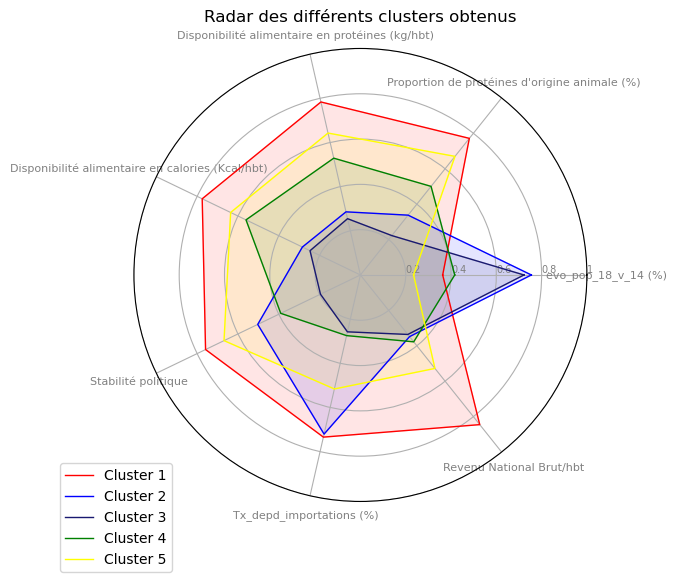

In [47]:
# Choix du set data (à partir de la table des valeurs moyennées par Cluster): 
df_radar = table_moy_var.copy()
df_radar = df_radar.reset_index()
df_radar_VAR = df_radar[[
                       'evo_pop_18_v_14 (%)',"Proportion de protéines d'origine animale (%)",
                       'Disponibilité alimentaire en protéines (kg/hbt)', 'Disponibilité alimentaire en calories (Kcal/hbt)',
                       'Stabilité politique', 'Tx_depd_importations (%)', 'Revenu National Brut/hbt'
                        ]]
df_radar_CLUST = df_radar[['Cluster']]

# normalization : (df-df.mean())/df.std()
df_radar_norm_mean = (df_radar_VAR-df_radar_VAR.mean())/df_radar_VAR.std()
df_radar_norm_mean.insert(0, "Cluster", df_radar_CLUST, allow_duplicates=False)
# normalization : (df-df.min())/(df.max()-df.min())
df_radar_norm_minmax =(df_radar_VAR-df_radar_VAR.min())/(df_radar_VAR.max()-df_radar_VAR.min())
df_radar_norm_minmax.insert(0, "Cluster", df_radar_CLUST, allow_duplicates=False)
# normalization : 1/(1+exp(-(x-mean)/std))
df_radar_norm_softmax = 1/(1+np.exp(-(df_radar_VAR-df_radar_VAR.mean())/df_radar_VAR.std()))
df_radar_norm_softmax.insert(0, "Cluster", df_radar_CLUST, allow_duplicates=False)

# Nb de variable
df = df_radar_norm_softmax.copy()
categories=list(df)[1:]
N = len(categories)
 
# On crée les angles entre les diff variables?
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':100})

# Initialisation du radar
ax = plt.subplot(111, polar=True)
 
# 1 axe par var + add labels
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# ylabels
ax.set_rlabel_position(0)
plt.yticks([0.2,0.4,0.6,0.8,1], ['0.2','0.4','0.6','0.8','1'], color="grey", size=7)
plt.ylim(0,1)
plt.title('Radar des différents clusters obtenus')

my_colors = ['red', 'blue', 'midnightblue', 'green', 'yellow']
                                         
# Refined
values=df.loc[0].drop('Cluster').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Cluster 1",color='red')
ax.fill(angles, values, 'b', alpha=0.1,color='red')
 
values=df.loc[1].drop('Cluster').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Cluster 2",color='blue')
ax.fill(angles, values, 'r', alpha=0.1,color='blue')

values=df.loc[2].drop('Cluster').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Cluster 3",color='midnightblue')
ax.fill(angles, values, 'b', alpha=0.1,color='midnightblue')
 
values=df.loc[3].drop('Cluster').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Cluster 4",color='green')
ax.fill(angles, values, 'r', alpha=0.1,color='green')

values=df.loc[4].drop('Cluster').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Cluster 5",color='yellow')
ax.fill(angles, values, 'b', alpha=0.1,color='yellow')

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.savefig("OUTPUTS_FORMATION/P5_radar_initial_C5_17_countries.jpg",dpi=300)
plt.show()

#### Stats descriptives : Distributions Gaussiennes

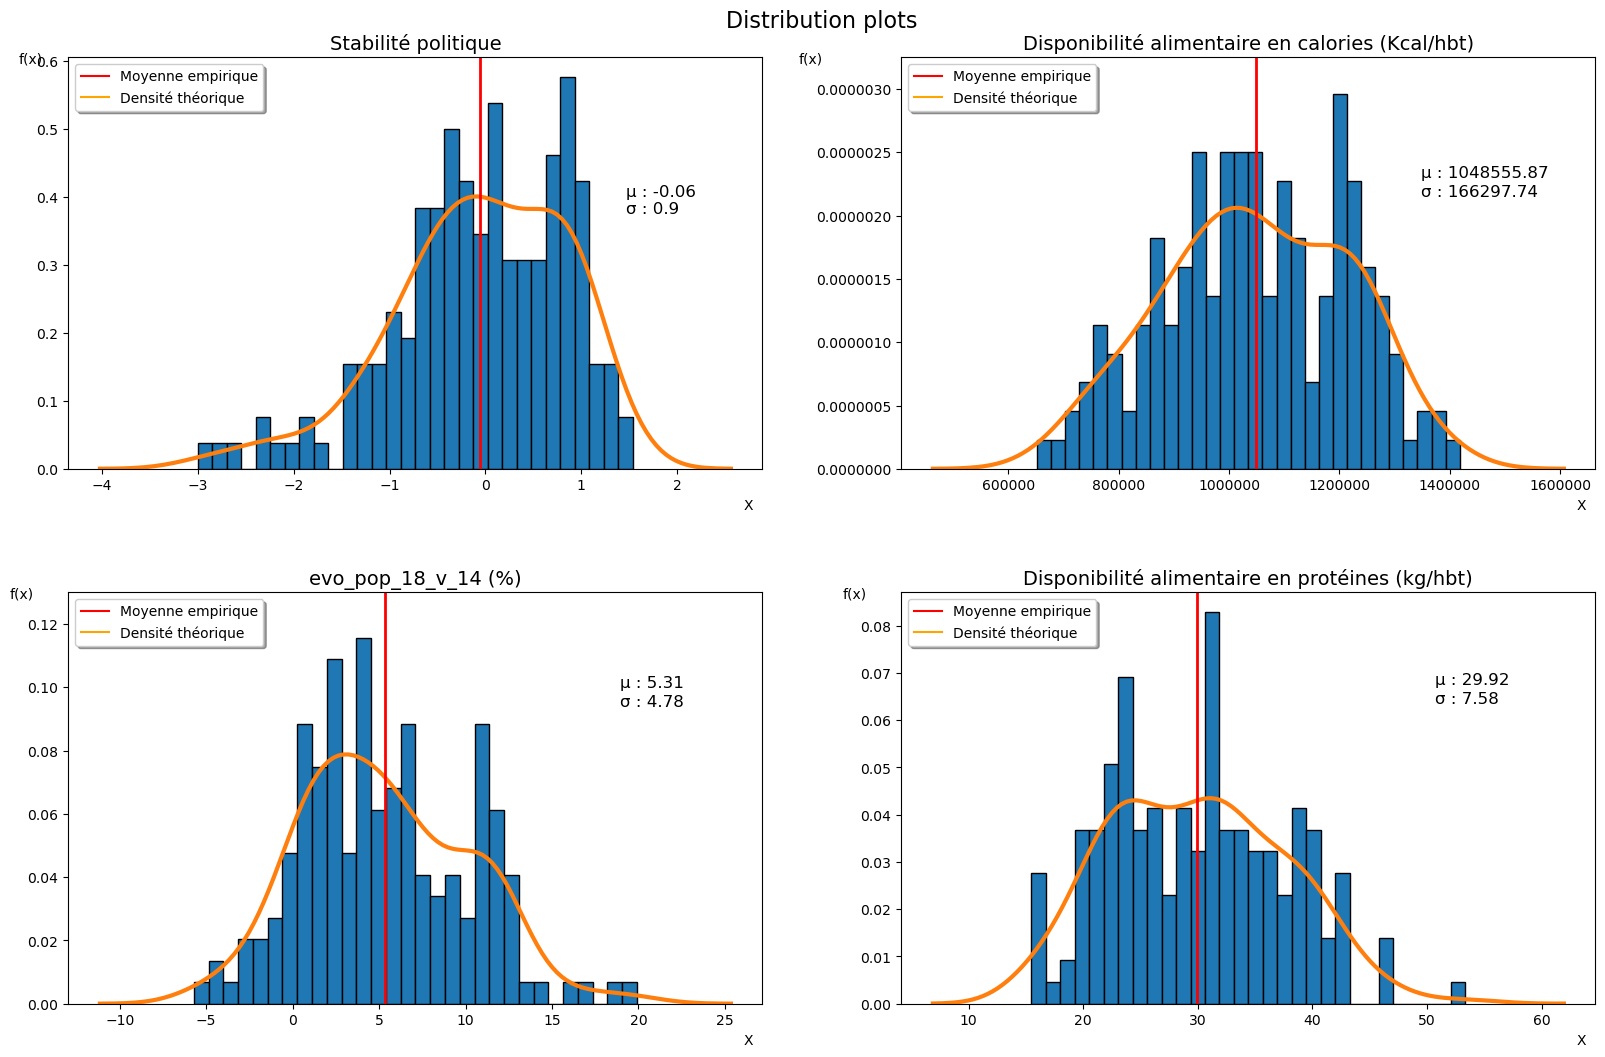

In [48]:
# 'evo_pop_18_v_14 (%)'
# "Proportion de protéines d'origine animale (%)"
# 'Disponibilité alimentaire en protéines (kg/hbt)'
# 'Disponibilité alimentaire en calories (Kcal/hbt)'
# 'Stabilité politique'
# 'Tx_depd_importations (%)'
# 'Revenu National Brut/hbt'
# 'Distance (km)'
# 'Tx_autosuffisance (%)'
# 'D Exports-Imports'
# 'Réserves'
# 'Exportations - Quantité'
# 'Importations - Quantité'
# 'Production'
    
VAR_1 =  table_vf_ALL['Stabilité politique']
VAR_2 =  table_vf_ALL['Disponibilité alimentaire en calories (Kcal/hbt)']
VAR_3 =  table_vf_ALL['evo_pop_18_v_14 (%)']
VAR_4 =  table_vf_ALL['Disponibilité alimentaire en protéines (kg/hbt)']

# moyenne
xbar    = np.mean(VAR_1)
# écart-type
sprime  = np.std(VAR_1, ddof=1)
# variance “non-biaisée” => A RETENIR
sprime2 = np.var(VAR_1, ddof=1)
# variance “biaisée”
v       = np.var(VAR_1)

plt.subplots(figsize=(16, 16))
plt.suptitle("Distribution plots", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.subplot(3, 2, 1)
# -----------------------------------------------------------------------------------Tracé histo + moyenne + densité gaussienne
sns.distplot(VAR_1, bins=30,
             kde_kws={"color": "tab:orange", "lw": 3},
             hist_kws={"histtype": "bar", "lw": 1,"alpha": 1, "color": "tab:blue","edgecolor":"black"})
plt.axvline(np.mean(VAR_1), color='r', linewidth=2)
# -----------------------------------------------------------------------------------Légende
import matplotlib.lines as mlines
colors = {'Moyenne empirique':'red', 'Densité théorique':'orange'}         
labels = list(colors.keys())
handles = [mlines.Line2D([], [], color=colors[label]) for label in labels] 
plt.legend(handles, labels, ncol=1, shadow=True, loc='upper left',fontsize=10)
plt.text(0.95*np.max(VAR_1),0.4 , "µ : "+str(round(np.mean(VAR_1),2)),fontsize=12)
plt.text(0.95*np.max(VAR_1),0.375, "σ : "+str(round(np.std(VAR_1, ddof=1),2)),fontsize=12)
# -----------------------------------------------------------------------------------Descriptifs
plt.title(str(VAR_1.name), fontsize=14)
plt.xlabel("X", position=(0.98,0))
plt.ylabel("f(x)", position=(0,0.98),rotation = 0)


plt.subplot(3, 2, 2)
# -----------------------------------------------------------------------------------Tracé histo + moyenne + densité gaussienne
sns.distplot(VAR_2, bins=30,
             kde_kws={"color": "tab:orange", "lw": 3},
             hist_kws={"histtype": "bar", "lw": 1,"alpha": 1, "color": "tab:blue","edgecolor":"black"})
plt.axvline(np.mean(VAR_2), color='r', linewidth=2)
# -----------------------------------------------------------------------------------Légende
import matplotlib.lines as mlines
colors = {'Moyenne empirique':'red', 'Densité théorique':'orange'}         
labels = list(colors.keys())
handles = [mlines.Line2D([], [], color=colors[label]) for label in labels] 
plt.legend(handles, labels, ncol=1, shadow=True, loc='upper left',fontsize=10)
plt.text(0.95*np.max(VAR_2),2.3e-6 , "µ : "+str(round(np.mean(VAR_2),2)),fontsize=12)
plt.text(0.95*np.max(VAR_2),2.15e-6, "σ : "+str(round(np.std(VAR_2, ddof=1),2)),fontsize=12)
# -----------------------------------------------------------------------------------Descriptifs
plt.title(str(VAR_2.name), fontsize=14)
plt.xlabel("X", position=(0.98,0))
plt.ylabel("f(x)", position=(0,0.98),rotation = 0)
plt.ticklabel_format(useOffset=False, style='plain')
plt.ylim(0,3.25e-6)


plt.subplot(3, 2, 3)
# -----------------------------------------------------------------------------------Tracé histo + moyenne + densité gaussienne
sns.distplot(VAR_3, bins=30,
             kde_kws={"color": "tab:orange", "lw": 3},
             hist_kws={"histtype": "bar", "lw": 1,"alpha": 1, "color": "tab:blue","edgecolor":"black"})
plt.axvline(np.mean(VAR_3), color='r', linewidth=2)
# -----------------------------------------------------------------------------------Légende
import matplotlib.lines as mlines
colors = {'Moyenne empirique':'red', 'Densité théorique':'orange'}         
labels = list(colors.keys())
handles = [mlines.Line2D([], [], color=colors[label]) for label in labels] 
plt.legend(handles, labels, ncol=1, shadow=True, loc='upper left',fontsize=10)
plt.text(0.95*np.max(VAR_3),0.10 , "µ : "+str(round(np.mean(VAR_3),2)),fontsize=12)
plt.text(0.95*np.max(VAR_3),0.094, "σ : "+str(round(np.std(VAR_3, ddof=1),2)),fontsize=12)
# -----------------------------------------------------------------------------------Descriptifs
plt.title(str(VAR_3.name), fontsize=14)
plt.xlabel("X", position=(0.98,0))
plt.ylabel("f(x)", position=(0,0.98),rotation = 0)
plt.ylim(0,0.13)


plt.subplot(3, 2, 4)
# -----------------------------------------------------------------------------------Tracé histo + moyenne + densité gaussienne
sns.distplot(VAR_4, bins=30,
             kde_kws={"color": "tab:orange", "lw": 3},
             hist_kws={"histtype": "bar", "lw": 1,"alpha": 1, "color": "tab:blue","edgecolor":"black"})
plt.axvline(np.mean(VAR_4), color='r', linewidth=2)
# -----------------------------------------------------------------------------------Légende
import matplotlib.lines as mlines
colors = {'Moyenne empirique':'red', 'Densité théorique':'orange'}         
labels = list(colors.keys())
handles = [mlines.Line2D([], [], color=colors[label]) for label in labels] 
plt.legend(handles, labels, ncol=1, shadow=True, loc='upper left',fontsize=10)
plt.text(0.95*np.max(VAR_4),0.0675 , "µ : "+str(round(np.mean(VAR_4),2)),fontsize=12)
plt.text(0.95*np.max(VAR_4),0.0635, "σ : "+str(round(np.std(VAR_4, ddof=1),2)),fontsize=12)
# -----------------------------------------------------------------------------------Descriptifs
plt.title(str(VAR_4.name), fontsize=14)
plt.xlabel("X", position=(0.98,0))
plt.ylabel("f(x)", position=(0,0.98),rotation = 0)
plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.savefig("OUTPUTS_FORMATION/P5_distri_Gauss.jpg",dpi=300)

#### Stats descriptives : Diagrammes Quantile-Quantile

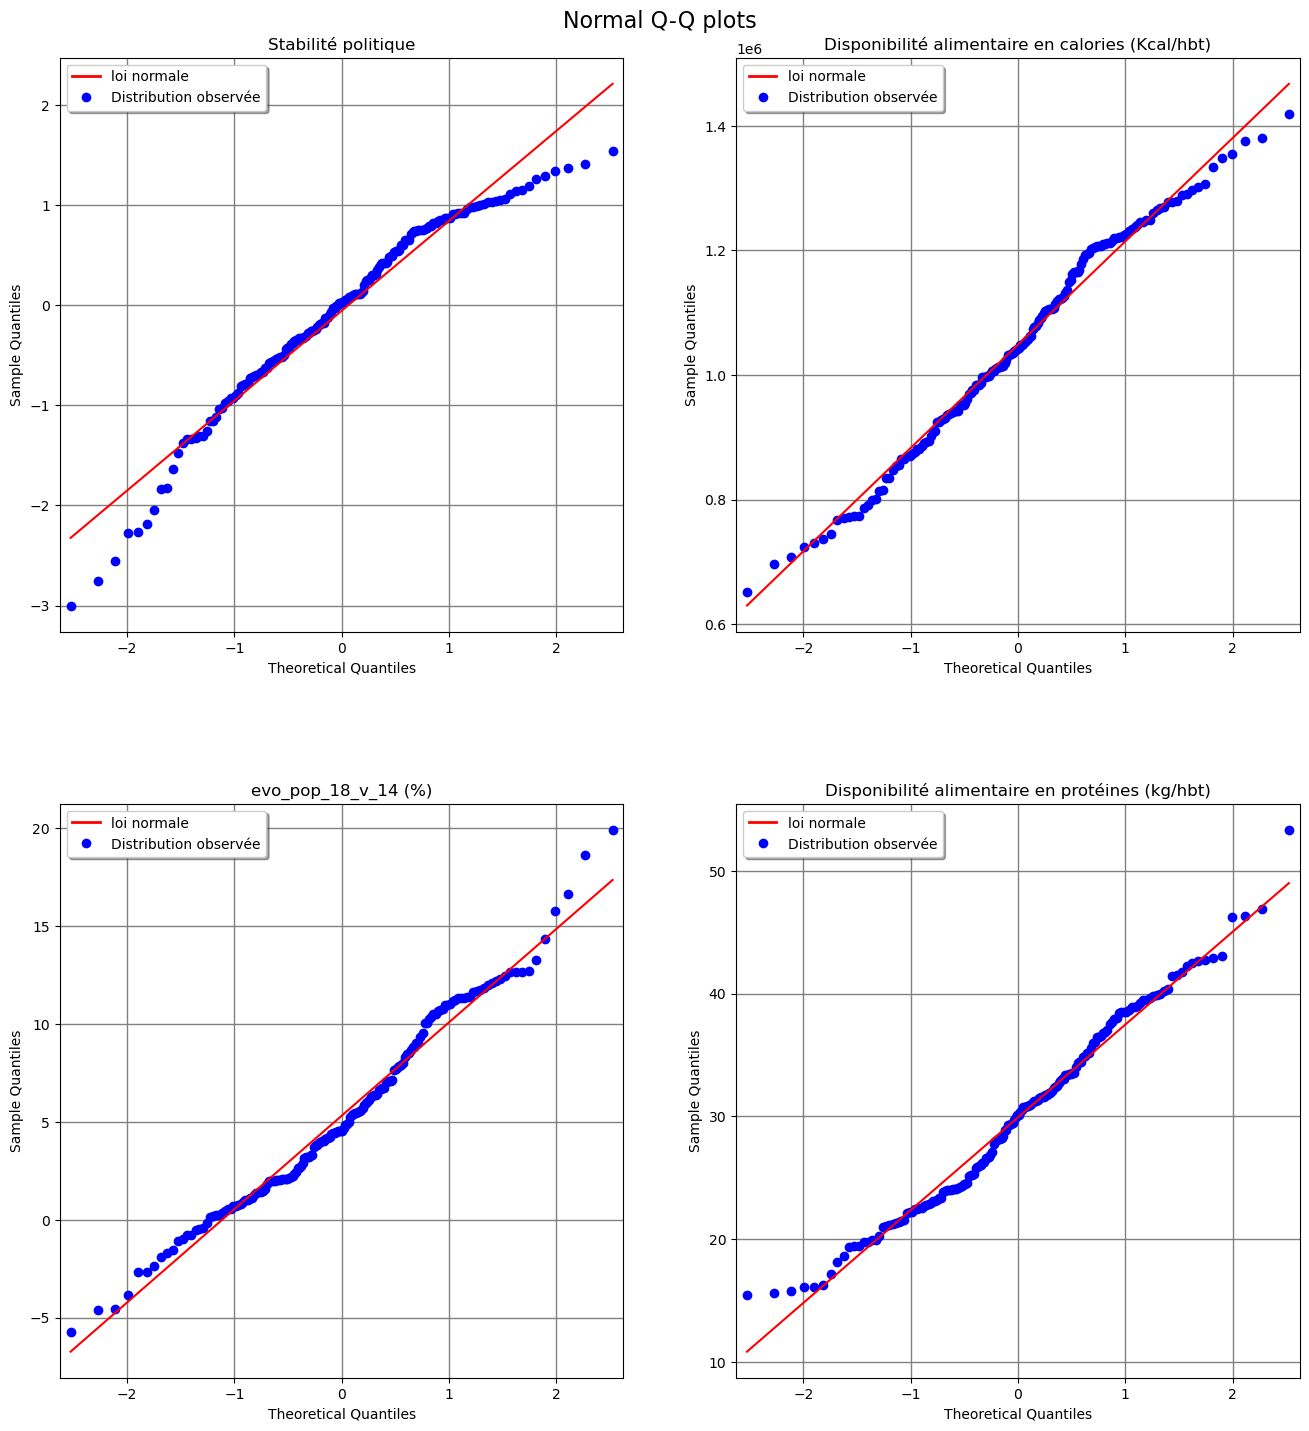

In [49]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import statsmodels.api as sm

# plt.subplots(figsize=(16, 16))
# plt.suptitle("Distribution plots", fontsize=16)
# plt.tight_layout()
# plt.subplots_adjust(top=0.95)

fig = plt.figure(figsize=(16, 16))
plt.suptitle("Normal Q-Q plots", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
ax = fig.add_subplot(2, 2, 1)
sm.graphics.qqplot(VAR_1, line='s', ax=ax)
plt.title(str(VAR_1.name),fontsize=12)
plt.xlabel("Theoretical Quantiles",fontsize=10)
plt.ylabel("Sample Quantiles",fontsize=10)
plt.grid(color='gray', linestyle='-', linewidth=1)
plt.grid(True)
legend_elements = [
                   Line2D([0], [0], color='red', lw=2, label='loi normale'),
                   Line2D([0], [0], marker='o', color='white', label='Distribution observée',markerfacecolor='b', markersize=8),
                  ]
ax.legend(handles=legend_elements, loc='upper left',shadow=True)

ax = fig.add_subplot(2, 2, 2)
sm.graphics.qqplot(VAR_2, line='s', ax=ax)
plt.title(str(VAR_2.name),fontsize=12)
plt.xlabel("Theoretical Quantiles",fontsize=10)
plt.ylabel("Sample Quantiles",fontsize=10)
plt.grid(color='gray', linestyle='-', linewidth=1)
plt.grid(True)
legend_elements = [
                   Line2D([0], [0], color='red', lw=2, label='loi normale'),
                   Line2D([0], [0], marker='o', color='white', label='Distribution observée',markerfacecolor='b', markersize=8),
                  ]
ax.legend(handles=legend_elements, loc='upper left',shadow=True)

ax = fig.add_subplot(2, 2, 3)
sm.graphics.qqplot(VAR_3, line='s', ax=ax)
plt.title(str(VAR_3.name),fontsize=12)
plt.xlabel("Theoretical Quantiles",fontsize=10)
plt.ylabel("Sample Quantiles",fontsize=10)
plt.grid(color='gray', linestyle='-', linewidth=1)
plt.grid(True)
legend_elements = [
                   Line2D([0], [0], color='red', lw=2, label='loi normale'),
                   Line2D([0], [0], marker='o', color='white', label='Distribution observée',markerfacecolor='b', markersize=8),
                  ]
ax.legend(handles=legend_elements, loc='upper left',shadow=True)

ax = fig.add_subplot(2, 2, 4)
sm.graphics.qqplot(VAR_4, line='s', ax=ax)
plt.title(str(VAR_4.name),fontsize=12)
plt.xlabel("Theoretical Quantiles",fontsize=10)
plt.ylabel("Sample Quantiles",fontsize=10)
plt.grid(color='gray', linestyle='-', linewidth=1)
plt.grid(True)
legend_elements = [
                   Line2D([0], [0], color='red', lw=2, label='loi normale'),
                   Line2D([0], [0], marker='o', color='white', label='Distribution observée',markerfacecolor='b', markersize=8),
                  ]
ax.legend(handles=legend_elements, loc='upper left',shadow=True)

plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.savefig("OUTPUTS_FORMATION/P5_QQplots.jpg",dpi=300)

#### Normality statistic test : Kolmogorov-Smirnov

In [50]:
from scipy.stats import ks_2samp
x=[VAR_1, VAR_2, VAR_3, VAR_4]
p_value     =[]
D_statistic =[]
statut_norm =[]
for i in x: 
    KS=ks_2samp(i,list(np.random.normal(np.mean(i), np.std(i), 1000)))
#     print(KS)
    print('\x1b[6;33;40m',f"{'D absolute max distance = ' : <10}{round(KS.statistic,3)}",'\x1b[0m')
    print('\x1b[6;33;40m',f"{'p-value                 = ' : <10}{round(KS.pvalue,5)}",'\x1b[0m')
    if KS.pvalue > 0.05 :
        print('\x1b[6;32;40m',"Avec une p_value > 5%, on accepte l’hypothèse de normalité (Ho). \n On peut considérer que la variable "+str(i.name.upper())+" suit une distribution normale.",'\x1b[0m')  
    else :
        print('\x1b[6;31;40m',"Avec une p_value << 5%, on ne peut pas retenir l’hypothèse de normalité (Ho). \n On peut considérer que la variable "+str(i.name.upper())+" ne suit pas une distribution normale.",'\x1b[0m')
    print('')
    D_statistic.append(KS.statistic)
    p_value.append(KS.pvalue)
    if KS.pvalue > 0.05:
        statut_norm.append("normal")
    else :
        statut_norm.append("#")
results = [D_statistic,p_value,statut_norm]
index   = ['D_statistic','p_value','Normality']
columns = [VAR_1.name, VAR_2.name, VAR_3.name, VAR_4.name]
df_KS   = pd.DataFrame(data=results, index=index, columns=columns)
df_KS

 D absolute max distance = 0.074 
 p-value                 = 0.37995 
 Avec une p_value > 5%, on accepte l’hypothèse de normalité (Ho). 
 On peut considérer que la variable STABILITÉ POLITIQUE suit une distribution normale. 

 D absolute max distance = 0.081 
 p-value                 = 0.268 
 Avec une p_value > 5%, on accepte l’hypothèse de normalité (Ho). 
 On peut considérer que la variable DISPONIBILITÉ ALIMENTAIRE EN CALORIES (KCAL/HBT) suit une distribution normale. 

 D absolute max distance = 0.08 
 p-value                 = 0.28965 
 Avec une p_value > 5%, on accepte l’hypothèse de normalité (Ho). 
 On peut considérer que la variable EVO_POP_18_V_14 (%) suit une distribution normale. 

 D absolute max distance = 0.074 
 p-value                 = 0.37767 
 Avec une p_value > 5%, on accepte l’hypothèse de normalité (Ho). 
 On peut considérer que la variable DISPONIBILITÉ ALIMENTAIRE EN PROTÉINES (KG/HBT) suit une distribution normale. 



,Stabilité politique,Disponibilité alimentaire en calories (Kcal/hbt),evo_pop_18_v_14 (%),Disponibilité alimentaire en protéines (kg/hbt)
D_statistic,0.073814,0.081442,0.079814,0.073953
p_value,0.379948,0.267998,0.289655,0.377669
Normality,normal,normal,normal,normal


#### Normality statistic test : Shapiro-Wilk ( /!\ sample size)

In [51]:
# obj: NE PAS REJETER Ho (la var a une distribution normale dans la population)
# En pratique, on cherche à limiter le risque de se tromper en obtenant une p_value>0.20 (ne pas se contenter de p_value>0.05)
from scipy import stats as st  
x=[VAR_1, VAR_2, VAR_3, VAR_4]
p_value    =[]
W_statistic=[]
statut_norm=[]
for i in x: 
    shap=st.shapiro(i)
#     print(shap)
    print('\x1b[6;33;40m',f"{'W test statistic = ' : <10}{round(st.shapiro(i).statistic,3)}",'\x1b[0m')
    print('\x1b[6;33;40m',f"{'p-value          = ' : <10}{round(st.shapiro(i).pvalue,5)}",'\x1b[0m')
    if shap.pvalue > 0.05 :
        print('\x1b[6;32;40m',"Avec une p_value > 5%, on accepte l’hypothèse de normalité (Ho). \n On peut considérer que la variable "+str(i.name.upper())+" suit une distribution normale.",'\x1b[0m')
    else :
        print('\x1b[6;31;40m',"Avec une p_value << 5%, on ne peut pas retenir l’hypothèse de normalité (Ho). \n On peut considérer que la variable "+str(i.name.upper())+" ne suit pas une distribution normale.",'\x1b[0m')
    print('')
    W_statistic.append(shap.statistic)
    p_value.append(shap.pvalue)
    if shap.pvalue > 0.05:
        statut_norm.append("normal")
    else :
        statut_norm.append("#")
results = [W_statistic,p_value,statut_norm]
index   = ['W_statistic','p_value','Normality']
columns = [VAR_1.name, VAR_2.name, VAR_3.name, VAR_4.name]
df_Shapiro = pd.DataFrame(data=results, index=index, columns=columns)
df_Shapiro   

 W test statistic = 0.96 
 p-value          = 8e-05 
 Avec une p_value << 5%, on ne peut pas retenir l’hypothèse de normalité (Ho). 
 On peut considérer que la variable STABILITÉ POLITIQUE ne suit pas une distribution normale. 

 W test statistic = 0.986 
 p-value          = 0.08207 
 Avec une p_value > 5%, on accepte l’hypothèse de normalité (Ho). 
 On peut considérer que la variable DISPONIBILITÉ ALIMENTAIRE EN CALORIES (KCAL/HBT) suit une distribution normale. 

 W test statistic = 0.982 
 p-value          = 0.02566 
 Avec une p_value << 5%, on ne peut pas retenir l’hypothèse de normalité (Ho). 
 On peut considérer que la variable EVO_POP_18_V_14 (%) ne suit pas une distribution normale. 

 W test statistic = 0.982 
 p-value          = 0.02815 
 Avec une p_value << 5%, on ne peut pas retenir l’hypothèse de normalité (Ho). 
 On peut considérer que la variable DISPONIBILITÉ ALIMENTAIRE EN PROTÉINES (KG/HBT) ne suit pas une distribution normale. 



,Stabilité politique,Disponibilité alimentaire en calories (Kcal/hbt),evo_pop_18_v_14 (%),Disponibilité alimentaire en protéines (kg/hbt)
W_statistic,0.960098,0.985949,0.982063,0.982375
p_value,0.00008,0.082067,0.025659,0.028153
Normality,#,normal,#,#


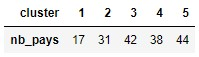

#### Homoscedasticity statistic test : Bartlett

In [52]:
# comparaison 2 populations dans cas gaussien
clustocomp_1 =  1                           # choisir ici le 1er cluster à comparer
clustocomp_2 =  4                           # choisir ici le 2d cluster

In [53]:
from scipy.stats import bartlett
varGAUSS_1 =  'Stabilité politique'
varGAUSS_2 =  'Disponibilité alimentaire en calories (Kcal/hbt)'
varGAUSS_3 =  'evo_pop_18_v_14 (%)'
varGAUSS_4 =  'Disponibilité alimentaire en protéines (kg/hbt)'
x=[varGAUSS_1, varGAUSS_2, varGAUSS_3, varGAUSS_4]
p_value    =[]
Statistic  =[]
statut_var =[]
for i in x: 
    table_comp_vGauss_C1 = table_vf[table_vf['Cluster'] == clustocomp_1][i]   # choisir ici le 1er cluster à comparer
    table_comp_vGauss_C2 = table_vf[table_vf['Cluster'] == clustocomp_2][i]   # choisir ici le 2d cluster
    stat, p = bartlett(table_comp_vGauss_C1,table_comp_vGauss_C2)
    print('\x1b[6;33;40m',f"{'Statistic = ' : <10}{round(stat,2)}",'\x1b[0m')
    print('\x1b[6;33;40m',f"{'p-value   = ' : <10}{round(p   ,7)}",'\x1b[0m')
    if p < 0.05 :
        print('\x1b[6;31;40m',"Avec une p_value < 5%, on peut considérer que les 2 populations n'ont pas la même variance "+str(i.upper())+".",'\x1b[0m')
    else :
        print('\x1b[6;32;40m',"Avec une p_value > 5%, on peut considérer que les 2 populations présentent la même variance "+str(i.upper())+".",'\x1b[0m')
    print('')
    Statistic.append(stat)
    p_value.append(p)
    if p < 0.05:
        statut_var.append("diff")
    else :
        statut_var.append("equal")
results = [Statistic, p_value, statut_var]
index   = ['Statistic','p_value','Variance']
columns = [varGAUSS_1, varGAUSS_2, varGAUSS_3, varGAUSS_4]
df_Bartlett = pd.DataFrame(data=results, index=index, columns=columns)
df_Bartlett

 Statistic = 8.26 
 p-value   = 0.0040423 
 Avec une p_value < 5%, on peut considérer que les 2 populations n'ont pas la même variance STABILITÉ POLITIQUE. 

 Statistic = 0.19 
 p-value   = 0.6659461 
 Avec une p_value > 5%, on peut considérer que les 2 populations présentent la même variance DISPONIBILITÉ ALIMENTAIRE EN CALORIES (KCAL/HBT). 

 Statistic = 1.26 
 p-value   = 0.2613259 
 Avec une p_value > 5%, on peut considérer que les 2 populations présentent la même variance EVO_POP_18_V_14 (%). 

 Statistic = 0.46 
 p-value   = 0.4986165 
 Avec une p_value > 5%, on peut considérer que les 2 populations présentent la même variance DISPONIBILITÉ ALIMENTAIRE EN PROTÉINES (KG/HBT). 



,Stabilité politique,Disponibilité alimentaire en calories (Kcal/hbt),evo_pop_18_v_14 (%),Disponibilité alimentaire en protéines (kg/hbt)
Statistic,8.264696,0.186381,1.261719,0.45788
p_value,0.004042,0.665946,0.261326,0.498616
Variance,diff,equal,equal,equal


#### Homoscedasticity statistic test : Levene

In [54]:
from scipy.stats import levene

# alternative to Bartlett’s test in the case where there are significant deviations from normality
varGAUSS_1 =  'Stabilité politique'
varGAUSS_2 =  'Disponibilité alimentaire en calories (Kcal/hbt)'
varGAUSS_3 =  'evo_pop_18_v_14 (%)'
varGAUSS_4 =  'Disponibilité alimentaire en protéines (kg/hbt)'
x=[varGAUSS_1, varGAUSS_2, varGAUSS_3, varGAUSS_4]
p_value    =[]
Statistic  =[]
statut_var =[]
for i in x: 
    table_comp_vGauss_C1 = table_vf[table_vf['Cluster'] == clustocomp_1][i]   
    table_comp_vGauss_C2 = table_vf[table_vf['Cluster'] == clustocomp_2][i]   
    stat, p = levene(table_comp_vGauss_C1,table_comp_vGauss_C2)
    print('\x1b[6;33;40m',f"{'Statistic = ' : <10}{round(stat,2)}",'\x1b[0m')
    print('\x1b[6;33;40m',f"{'p-value   = ' : <10}{round(p   ,7)}",'\x1b[0m')
    if p < 0.05 :
        print('\x1b[6;31;40m',"Avec une p_value < 5%, on peut considérer que les 2 populations n'ont pas la même variance "+str(i.upper())+".",'\x1b[0m')
    else :
        print('\x1b[6;32;40m',"Avec une p_value > 5%, on peut considérer que les 2 populations présentent la même variance "+str(i.upper())+".",'\x1b[0m')
    print('')
    Statistic.append(stat)
    p_value.append(p)
    if p < 0.05:
        statut_var.append("diff")
    else :
        statut_var.append("equal")
results = [Statistic, p_value, statut_var]
index   = ['Statistic','p_value','Variance']
columns = [varGAUSS_1, varGAUSS_2, varGAUSS_3, varGAUSS_4]
df_Levene = pd.DataFrame(data=results, index=index, columns=columns)
df_Levene

 Statistic = 5.25 
 p-value   = 0.0259578 
 Avec une p_value < 5%, on peut considérer que les 2 populations n'ont pas la même variance STABILITÉ POLITIQUE. 

 Statistic = 0.24 
 p-value   = 0.6287028 
 Avec une p_value > 5%, on peut considérer que les 2 populations présentent la même variance DISPONIBILITÉ ALIMENTAIRE EN CALORIES (KCAL/HBT). 

 Statistic = 2.04 
 p-value   = 0.1586468 
 Avec une p_value > 5%, on peut considérer que les 2 populations présentent la même variance EVO_POP_18_V_14 (%). 

 Statistic = 0.07 
 p-value   = 0.7989081 
 Avec une p_value > 5%, on peut considérer que les 2 populations présentent la même variance DISPONIBILITÉ ALIMENTAIRE EN PROTÉINES (KG/HBT). 



,Stabilité politique,Disponibilité alimentaire en calories (Kcal/hbt),evo_pop_18_v_14 (%),Disponibilité alimentaire en protéines (kg/hbt)
Statistic,5.249433,0.236566,2.044291,0.065559
p_value,0.025958,0.628703,0.158647,0.798908
Variance,diff,equal,equal,equal


#### Student test

In [55]:
# print(st.ttest_ind(table_comp_vGauss_C1,table_comp_vGauss_C2, equal_var=True))
print('\x1b[6;31;40m',"Invalidation des Hypothèses de : \n 1) Normalité \n 2) Homoscédasticité",'\x1b[0m')
print('\x1b[6;31;40m',"=> On ne peut donc conclure quant à la différence entre les clusters.",'\x1b[0m')

 Invalidation des Hypothèses de : 
 1) Normalité 
 2) Homoscédasticité 
 => On ne peut donc conclure quant à la différence entre les clusters. 


#### Non-parametric statistic test (non-normality)

- Mann-Whitney U test for comparing independent data samples: nonparametric version of the Student t-test
- Wilcoxon signed-rank test for comparing paired data samples: nonparametric version of the paired Student t-test
- Kruskal-Wallis H (independant, nonparametric version of the ANOVA) and Friedman (paired, repeated measures ANOVA) tests for comparing more than two data samples: can be thought of as the generalization of the Mann-Whitney U test

In [56]:
from scipy.stats import mannwhitneyu,wilcoxon
# two-sample wilcoxon test a.k.a Mann Whitney U
varGAUSS_1 =  'Stabilité politique'
varGAUSS_2 =  'Disponibilité alimentaire en calories (Kcal/hbt)'
varGAUSS_3 =  'evo_pop_18_v_14 (%)'
varGAUSS_4 =  'Disponibilité alimentaire en protéines (kg/hbt)'
x=[varGAUSS_1, varGAUSS_2, varGAUSS_3, varGAUSS_4]
p_value    =[]
Statistic  =[]
statut_dist =[]
for i in x: 
    table_comp_vGauss_C1 = table_vf[table_vf['Cluster'] == clustocomp_1][i]   
    table_comp_vGauss_C2 = table_vf[table_vf['Cluster'] == clustocomp_2][i]   
    stat, p = mannwhitneyu(table_comp_vGauss_C1,table_comp_vGauss_C2)
    print('\x1b[6;33;40m',f"{'Statistic = ' : <10}{round(stat,2)}",'\x1b[0m')
    print('\x1b[6;33;40m','p=%.3e' %p,'\x1b[0m')
    if p < 0.05 :
        print('\x1b[6;31;40m',"Avec une p_value < 5%, different distribution (reject H0) "+str(i.upper())+".",'\x1b[0m')
    else :
        print('\x1b[6;32;40m',"Avec une p_value > 5%, same distribution (fail to reject H0) "+str(i.upper())+".",'\x1b[0m')
    print('')
    Statistic.append(stat)
    p_value.append(p)
    if p < 0.05:
        statut_dist.append("diff")
    else :
        statut_dist.append("equal")
results = [Statistic, p_value, statut_dist]
index   = ['Statistic','p_value','Distribution']
columns = [varGAUSS_1, varGAUSS_2, varGAUSS_3, varGAUSS_4]
df_MannWhitU = pd.DataFrame(data=results, index=index, columns=columns)
df_MannWhitU

 Statistic = 638.0 
 p=1.013e-08 
 Avec une p_value < 5%, different distribution (reject H0) STABILITÉ POLITIQUE. 

 Statistic = 573.0 
 p=5.514e-06 
 Avec une p_value < 5%, different distribution (reject H0) DISPONIBILITÉ ALIMENTAIRE EN CALORIES (KCAL/HBT). 

 Statistic = 249.5 
 p=1.837e-01 
 Avec une p_value > 5%, same distribution (fail to reject H0) EVO_POP_18_V_14 (%). 

 Statistic = 601.0 
 p=4.324e-07 
 Avec une p_value < 5%, different distribution (reject H0) DISPONIBILITÉ ALIMENTAIRE EN PROTÉINES (KG/HBT). 



,Stabilité politique,Disponibilité alimentaire en calories (Kcal/hbt),evo_pop_18_v_14 (%),Disponibilité alimentaire en protéines (kg/hbt)
Statistic,638.0,573.0,249.5,601.0
p_value,0.0,0.000006,0.18366,0.0
Distribution,diff,diff,equal,diff


#### Statistic decision tree

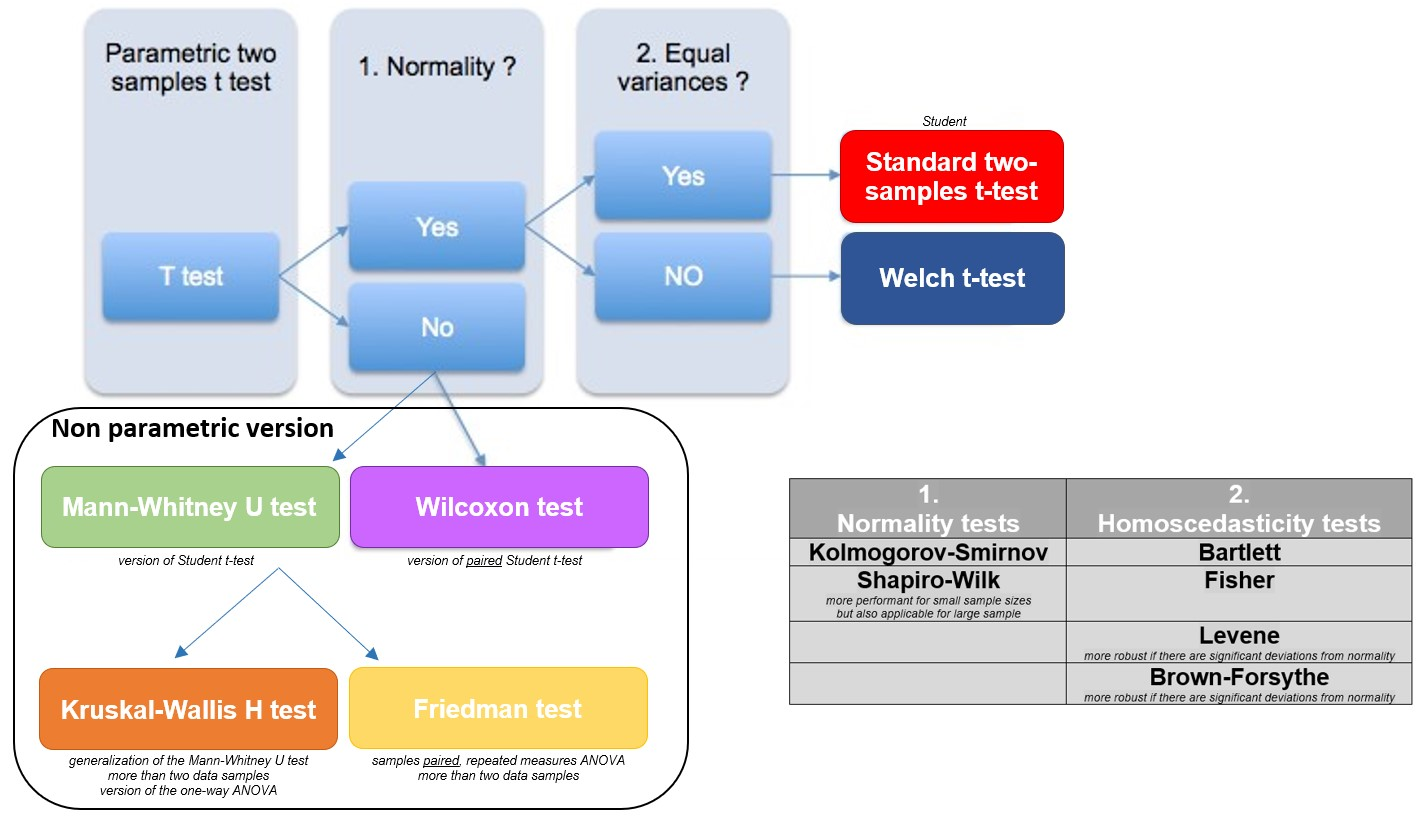